MODEL TRAINING AND SAVING THE TRAINED MODEL

Column names in the dataset:
'Timestamp'
'Age'
'Gender'
'Highest Education Level'
'Preferred Subjects in Highschool/College'
'Academic Performance (CGPA/Percentage)'
'Participation in Extracurricular Activities'
'Previous Work Experience (If Any)'
'Preferred Work Environment'
'Risk-Taking Ability '
'Leadership Experience'
'Networking & Social Skills'
'Tech-Savviness'
'Financial Stability - self/family (1 is low income and 10 is high income)'
'Motivation for Career Choice '
'Favorite Color'
'Daily Water Intake (in Litres) '
'Birth Month '
'Preferred Music Genre'
'Number of Siblings'
'What would you like to become when you grow up'
NaN values in features after filling:
Preferred Work Environment                                                   0
Academic Performance (CGPA/Percentage)                                       0
Motivation for Career Choice                                                 0
Leadership Experience                                                        0
Tech-Sav

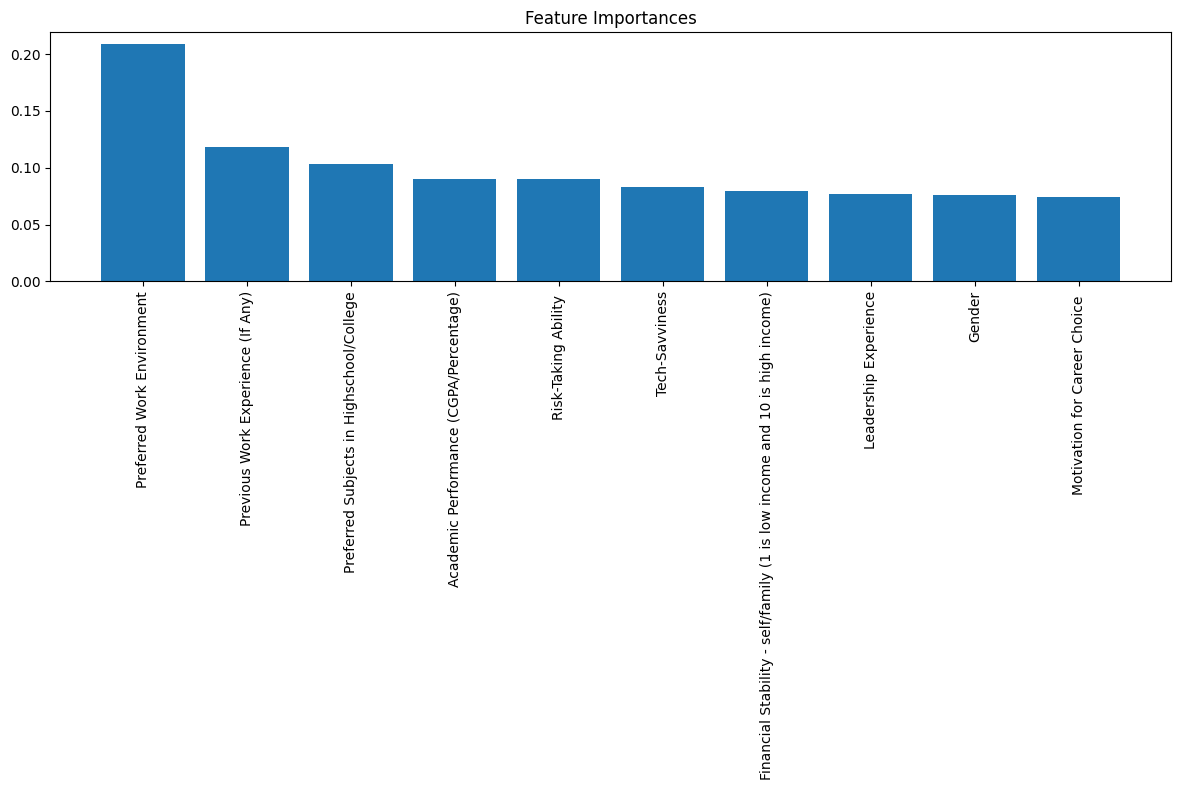

Model saved to c:\Users\bibek\Desktop\syntax squad\deployment\career_prediction_model.pkl
Model saved for judges' evaluation as Syntax_Squad.joblib


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gradio as gr
import os
import joblib

# Load the dataset with absolute path
df = pd.read_csv(r'c:\Users\bibek\Desktop\syntax squad\final_train.csv')

# Print column names to debug
print("Column names in the dataset:")
for col in df.columns:
    print(f"'{col}'")

# Data preprocessing
# Select primary and secondary features - note the space at the end of some column names
primary_features = [
    'Preferred Work Environment', 
    'Academic Performance (CGPA/Percentage)', 
    'Motivation for Career Choice ', 
    'Leadership Experience', 
    'Tech-Savviness',
    'Preferred Subjects in Highschool/College',  # Added new feature
    'Gender'
]

secondary_features = [
    'Risk-Taking Ability ',  # Note the space at the end
    'Financial Stability - self/family (1 is low income and 10 is high income)',
    'Previous Work Experience (If Any)'
]

# Combine features
features = primary_features + secondary_features
target = 'What would you like to become when you grow up'

# Handle missing values
df[features] = df[features].fillna('Unknown')
df[target] = df[target].fillna('Corporate Employee') 
df['Preferred Subjects in Highschool/College'] = df['Preferred Subjects in Highschool/College'].fillna('Unknown')
df['Gender'] = df['Gender'].fillna('Unknown')# Most common value as default

# Convert numeric features
# Convert Academic Performance to numeric
df['Academic Performance (CGPA/Percentage)'] = pd.to_numeric(
    df['Academic Performance (CGPA/Percentage)'], errors='coerce')
df['Academic Performance (CGPA/Percentage)'].fillna(
    df['Academic Performance (CGPA/Percentage)'].mean(), inplace=True)

# Convert Risk-Taking Ability to numeric
df['Risk-Taking Ability '] = pd.to_numeric(
    df['Risk-Taking Ability '], errors='coerce')
df['Risk-Taking Ability '].fillna(
    df['Risk-Taking Ability '].median(), inplace=True)

# Convert Financial Stability to numeric
df['Financial Stability - self/family (1 is low income and 10 is high income)'] = pd.to_numeric(
    df['Financial Stability - self/family (1 is low income and 10 is high income)'], errors='coerce')
df['Financial Stability - self/family (1 is low income and 10 is high income)'].fillna(
    df['Financial Stability - self/family (1 is low income and 10 is high income)'].median(), inplace=True)

# Check for any remaining NaN values
print("NaN values in features after filling:")
print(df[features].isna().sum())
print("NaN values in target after filling:")
print(df[target].isna().sum())

# Convert categorical features to numerical
label_encoders = {}
for feature in features:
    if df[feature].dtype == 'object':
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
        label_encoders[feature] = le
        print(f"Encoded {feature} with {len(le.classes_)} unique values")

# Encode the target variable
target_encoder = LabelEncoder()
df[target] = target_encoder.fit_transform(df[target])
target_classes = target_encoder.classes_

# Print unique target classes
print(f"Number of unique target classes: {len(target_classes)}")
print(f"Target classes: {target_classes}")

# Split the data
X = df[features]
y = df[target].astype(int)  # Ensure target is integer type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check data types before training
print("X_train dtype:", X_train.dtypes)
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)


print("\nTraining XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(target_classes),
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_estimators=200,
    eval_metric='mlogloss'
)

# Train the model - remove early_stopping_rounds
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# Get predictions
y_pred = xgb_model.predict(X_test)

# Ensure both are numpy arrays of the same dtype
y_test_array = np.array(y_test)
y_pred = np.array(y_pred).astype(y_test_array.dtype)

# Print shapes and types for debugging
print(f"y_test shape: {y_test_array.shape}, y_pred shape: {y_pred.shape}")
print(f"y_test dtype: {y_test_array.dtype}, y_pred dtype: {y_pred.dtype}")
print(f"y_test unique values: {np.unique(y_test_array)}")
print(f"y_pred unique values: {np.unique(y_pred)}")

# Calculate accuracy
accuracy = accuracy_score(y_test_array, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

# Generate classification report
try:
    print("\nClassification Report:")
    print(classification_report(y_test_array, y_pred, target_names=target_classes))
except Exception as e:
    print(f"Error generating classification report: {e}")

# Feature importance
print("\nFeature Importance:")
importance = xgb_model.feature_importances_
indices = np.argsort(importance)[::-1]

for i, idx in enumerate(indices):
    print(f"{i+1}. {features[idx]}: {importance[idx]:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importance[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig(r'c:\Users\bibek\Desktop\syntax squad\feature_importance.png')
plt.show()

# Save the model and encoders
model_path = r'c:\Users\bibek\Desktop\syntax squad\deployment\career_prediction_model.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

saved_data = {
    'model': xgb_model,
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'features': features,
    'primary_features': primary_features,
    'secondary_features': secondary_features
}

with open(model_path, 'wb') as f:
    pickle.dump(saved_data, f)
print(f"Model saved to {model_path}")

joblib.dump({
    'model': xgb_model,
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'features': features,
    'primary_features': primary_features,
    'secondary_features': secondary_features
}, 'Syntax_Squad.joblib')

print(f"Model saved for judges' evaluation as Syntax_Squad.joblib")

TESTING SAMPLES

In [6]:
# Testing the model with 10 samples from the dataset
print("\n--- Testing the model with 100 samples ---")

# First, let's make sure we're using the saved model (same as in test_model.py)
model_path = r'c:\Users\bibek\Desktop\syntax squad\deployment\career_prediction_model.pkl'
with open(model_path, 'rb') as f:
    saved_data = pickle.load(f)

# Extract model components from the saved file
test_model = saved_data['model']
test_label_encoders = saved_data['label_encoders']
test_target_encoder = saved_data['target_encoder']
test_features = saved_data['features']

# Print features to verify
print(f"Original training features: {features}")
print(f"Saved model features: {test_features}")

# Load fresh data for testing
test_df = pd.read_csv(r'c:\Users\bibek\Desktop\syntax squad\final_train.csv')
test_target = 'What would you like to become when you grow up'

# Preprocess the test data the same way as in test_model.py
test_df[test_features] = test_df[test_features].fillna('Unknown')
test_df[test_target] = test_df[test_target].fillna('Corporate Employee')

# Convert numeric features
test_df['Academic Performance (CGPA/Percentage)'] = pd.to_numeric(
    test_df['Academic Performance (CGPA/Percentage)'], errors='coerce')
test_df['Academic Performance (CGPA/Percentage)'].fillna(
    test_df['Academic Performance (CGPA/Percentage)'].mean(), inplace=True)

if 'Risk-Taking Ability ' in test_features:
    test_df['Risk-Taking Ability '] = pd.to_numeric(
        test_df['Risk-Taking Ability '], errors='coerce')
    test_df['Risk-Taking Ability '].fillna(
        test_df['Risk-Taking Ability '].median(), inplace=True)

if 'Financial Stability - self/family (1 is low income and 10 is high income)' in test_features:
    test_df['Financial Stability - self/family (1 is low income and 10 is high income)'] = pd.to_numeric(
        test_df['Financial Stability - self/family (1 is low income and 10 is high income)'], errors='coerce')
    test_df['Financial Stability - self/family (1 is low income and 10 is high income)'].fillna(
        test_df['Financial Stability - self/family (1 is low income and 10 is high income)'].median(), inplace=True)

# Select 100 random samples from the dataset
test_samples = test_df.sample(100, random_state=42)
X_test_samples = test_samples[test_features].copy()  # Create a copy to avoid modifying original

# Encode categorical features using the saved label encoders
for feature in test_features:
    if feature in test_label_encoders and X_test_samples[feature].dtype == 'object':
        try:
            X_test_samples[feature] = test_label_encoders[feature].transform(X_test_samples[feature])
        except ValueError as e:
            # Handle unknown categories
            print(f"Warning: Unknown category in {feature}. Using most frequent category.")
            X_test_samples[feature] = 0   # Default to first category

# Encode target
y_test_samples = test_samples[test_target]

# Make predictions
y_pred_samples = test_model.predict(X_test_samples)

# Convert predictions and actual values to career names
y_test_careers = y_test_samples.values  # Just use the values directly
y_pred_careers = test_target_encoder.inverse_transform(y_pred_samples.astype(int))

# Create a comparison dataframe
results_df = pd.DataFrame({
    'Expected': y_test_careers,
    'Predicted': y_pred_careers,
    'Match': y_test_careers == y_pred_careers
})

# Add key features for context
for feature in test_features:
    if feature in test_label_encoders and test_samples[feature].dtype == 'object':
        # For categorical features, use the original values from test_samples
        results_df[feature] = test_samples[feature].values
    else:
        # For numeric features, use values as is
        results_df[feature] = test_samples[feature].values

# Calculate and display accuracy
test_accuracy = results_df['Match'].mean()
print(f"Test accuracy on 100 samples: {test_accuracy:.2f}")

# Display the results
print("\nTest Results:")
print(results_df[['Expected', 'Predicted', 'Match']])

# Display detailed predictions with probabilities
print("\nDetailed Predictions:")
for i in range(len(results_df)):
    print(f"\nSample {i+1}:")
    print(f"Expected: {results_df['Expected'].iloc[i]}")
    print(f"Predicted: {results_df['Predicted'].iloc[i]}")
    print(f"Match: {'✓' if results_df['Match'].iloc[i] else '✗'}")
    
    # Get probabilities for all classes
    if hasattr(test_model, 'predict_proba'):
        sample_data = X_test_samples.iloc[[i]]
        probabilities = test_model.predict_proba(sample_data)[0]
        class_probs = {test_target_encoder.inverse_transform([j])[0]: prob 
                      for j, prob in enumerate(probabilities)}
        sorted_probs = dict(sorted(class_probs.items(), key=lambda x: x[1], reverse=True)[:3])  # Top 3 probabilities
        
        print("Top 3 Probabilities:")
        for career, prob in sorted_probs.items():
            print(f"  {career}: {prob:.2f}")
    
    # Print key features
    print("Key Features:")
    for feature in test_features:
        feature_value = results_df[feature].iloc[i]
        print(f"  {feature}: {feature_value}")


--- Testing the model with 100 samples ---
Original training features: ['Preferred Work Environment', 'Academic Performance (CGPA/Percentage)', 'Motivation for Career Choice ', 'Leadership Experience', 'Tech-Savviness', 'Preferred Subjects in Highschool/College', 'Gender', 'Risk-Taking Ability ', 'Financial Stability - self/family (1 is low income and 10 is high income)', 'Previous Work Experience (If Any)']
Saved model features: ['Preferred Work Environment', 'Academic Performance (CGPA/Percentage)', 'Motivation for Career Choice ', 'Leadership Experience', 'Tech-Savviness', 'Preferred Subjects in Highschool/College', 'Gender', 'Risk-Taking Ability ', 'Financial Stability - self/family (1 is low income and 10 is high income)', 'Previous Work Experience (If Any)']
Test accuracy on 100 samples: 0.91

Test Results:
              Expected           Predicted  Match
0         Entrepreneur        Entrepreneur   True
1   Government Officer        Entrepreneur  False
2   Government Officer  

USE THE BELOW LINK TO RUN THE MODEL

https://huggingface.co/spaces/WickedFaith/Syntax-Squad